## 1. 商業問題定義
- 將短文本自然群聚成主題以及關鍵字，方便快速吸收目前討論內容。
- 使用中文新聞公開資料。

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import jieba
# import umap
import umap.umap_ as umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import os

%matplotlib inline

In [2]:
tf.test.is_gpu_available()

True

## 2. 取得資料

In [3]:
os.listdir('../data')

['toutiao_cat_data.txt', 'toutiao_cat_data.txt.zip', '聊天室美國資料.csv']

In [4]:
text_name = os.path.join('../data', 'toutiao_cat_data.txt')

with open(text_name, 'r', encoding='utf-8') as f:
    data = f.read()
    
    
data[:100]

'6551700932705387022_!_101_!_news_culture_!_京城最值得你来场文化之旅的博物馆_!_保利集团,马未都,中国科学技术馆,博物馆,新中国\n6552368441838'

In [5]:
rows = data.split('\n')
len(rows)

382689

In [6]:
rows[0]

'6551700932705387022_!_101_!_news_culture_!_京城最值得你来场文化之旅的博物馆_!_保利集团,马未都,中国科学技术馆,博物馆,新中国'

In [7]:
%%time
## 將資料特徵透過_!_拆分


data = {
    'category': [],
    'content': [],
    'keywords': []
}

for row in rows:
    try:
        #print(row.split('_!_'))
        _, _, category, content, keywords = row.split('_!_')
        #print(category)
        #print(content)
        #print(keywords)
        data['category'].append(category)
        data['content'].append(content)
        data['keywords'].append(keywords)
    except:
        pass
    

Wall time: 240 ms


In [8]:
## 包裝成df

df = pd.DataFrame(data)
del data

print(df.shape)
df.head()

(382688, 3)


,category,content,keywords
0,news_culture,京城最值得你来场文化之旅的博物馆,"保利集团,马未都,中国科学技术馆,博物馆,新中国"
1,news_culture,发酵床的垫料种类有哪些？哪种更好？,
2,news_culture,上联：黄山黄河黄皮肤黄土高原。怎么对下联？,
3,news_culture,林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？,
4,news_culture,黄杨木是什么树？,


## 3. 特徵工程
- 斷詞

In [9]:
%%time
## 斷詞

df['content_seg'] = df['content'].apply(lambda x : ' '.join([j.strip() for j in jieba.cut(x)]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\AARONY~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.469 seconds.
Prefix dict has been built successfully.


Wall time: 27.9 s


,category,content,keywords,content_seg
0,news_culture,京城最值得你来场文化之旅的博物馆,"保利集团,马未都,中国科学技术馆,博物馆,新中国",京城 最 值得 你 来场 文化 之旅 的 博物馆
1,news_culture,发酵床的垫料种类有哪些？哪种更好？,,发酵 床 的 垫料 种类 有 哪些 ？ 哪 种 更好 ？
2,news_culture,上联：黄山黄河黄皮肤黄土高原。怎么对下联？,,上联 ： 黄山 黄河 黄皮肤 黄土高原 。 怎么 对 下联 ？
3,news_culture,林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？,,林徽因 什么 理由 拒绝 了 徐志摩 而 选择 梁思成 为 终身伴侣 ？
4,news_culture,黄杨木是什么树？,,黄杨木 是 什么 树 ？


In [10]:
## 因為資料這樣會太多，找一下子集測試就好

random_state = 222

df = df.sample(n=20000, random_state=random_state)
df.shape

(20000, 4)

## 4. 建模
- 文本向量化 - `sentence-transformer(SBERT)`
- 降維 - `UMAP`
- 分群 - `HDBSCAN`

---


值得注意的是，每一個動作都可以用別的演算法替代
- [另外需要處理sentence-transformer只用pytorch的窘境](https://www.philschmid.de/tensorflow-sentence-transformers)

In [11]:
%%time

## 文本向量化

model_name = 'uer/sbert-base-chinese-nli'
model = SentenceTransformer(model_name)

No sentence-transformers model found with name C:\Users\aaronyang/.cache\torch\sentence_transformers\uer_sbert-base-chinese-nli. Creating a new one with MEAN pooling.


Wall time: 7.62 s


In [12]:
df['content'].apply(lambda x: len(x)).max()

86

In [13]:
%%time

embeddings = model.encode(df['content'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Wall time: 6min 51s


In [14]:
# model.encode(['為什麼那麼久?']*10000, show_progress_bar=True)

In [15]:
embeddings.shape

(20000, 768)

In [16]:
embeddings

array([[ 0.8786188 ,  0.04504289,  0.26781574, ...,  1.2756814 ,
         0.14441015, -0.01514008],
       [ 0.28114983, -0.09786879, -0.5278394 , ...,  0.44912046,
        -0.81957537, -0.6127376 ],
       [ 0.11586589,  0.12935798, -0.70216423, ...,  0.7037909 ,
         0.07032794,  0.08633716],
       ...,
       [ 0.01355686,  0.17061996, -0.2338957 , ..., -0.6837768 ,
        -0.12829761,  0.5411159 ],
       [ 0.18979554, -0.65322584, -1.0788306 , ...,  0.46245766,
        -0.19942297, -0.03394207],
       [ 0.61205834,  0.34195483, -0.8787517 , ...,  0.02076899,
         0.3804629 ,  0.16369793]], dtype=float32)

In [17]:
%%time

## 降維

# 遇到"Random Projection forest initialisation failed due to recursion"

umap_embeddings = umap.UMAP(
    n_neighbors=25,
    n_components=10,
    metric='cosine',
    random_state=random_state
).fit_transform(embeddings)

C:\Users\aaronyang\AppData\Roaming\Python\Python37\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


Wall time: 43.2 s


In [20]:
%%time

## 分群

cluster = hdbscan.HDBSCAN(
    min_cluster_size=30,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
).fit(umap_embeddings)

Wall time: 5.44 s


In [27]:
## 將umap embedding降成2維搭配剛剛分群的label可以視覺化觀察

umap_data = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

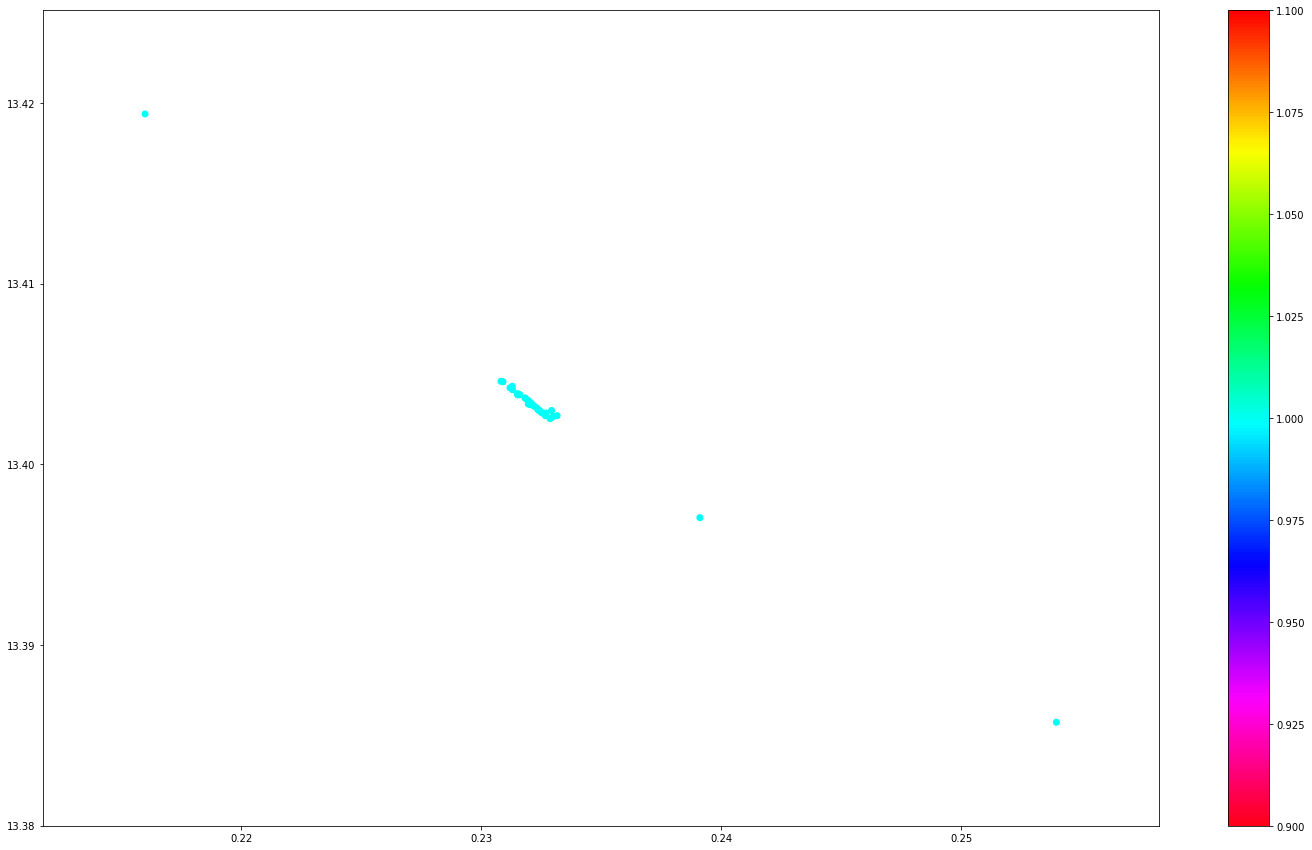

In [28]:
## 視覺化
fig, ax = plt.subplots(figsize=(25, 15))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels == 1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
plt.colorbar()

In [29]:
clustered.shape, outliers.shape

((36, 3), (253, 3))

> 使用的資料集可能不是太好

## 5. 應用
- c-TF-IDF

In [37]:
count = CountVectorizer(
    ngram_range=(1, 1),
).fit(df['content_seg'])

## 得到(總樣本數, 總詞數)
t = count.transform(df['content_seg']).toarray()
t.shape

(20000, 35374)

In [44]:
## 計算該檔案的總詞數

w = t.sum(axis=1)
w.shape

(20000,)

In [46]:
## 計算tf

tf = np.divide(t.T, w)
tf.shape

(35374, 20000)

In [47]:
## 計算特定詞出現總數

sum_t = t.sum(axis=0)
sum_t.shape

(35374,)

In [48]:
## 計算idf

m = len(df)

idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
idf.shape

(35374, 1)

In [50]:
# tfidf(總詞數, 總樣本數)

tf_idf = np.multiply(tf, idf)
tf_idf.shape

(35374, 20000)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []

df['content_seg'].apply(lambda x: corpus.append(x))

tfidf_vectorizer = TfidfVectorizer()
tfidf_sklearn = tfidf_vectorizer.fit_transform(corpus)
tfidf_sklearn.shape

(20000, 35374)

In [53]:
tfidf_sklearn == tf_idf.T

matrix([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])

In [54]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """
        將每一個群當作一個文本，來進行tfidf。
        ---
        為什麼不用 tf-idf 套件? 等等比對看看是否一樣 ---> 上面計算起來是一樣的。
        ---> 後續發現其實參照官方定義是不一樣的。https://maartengr.github.io/BERTopic/getting_started/ctfidf/ctfidf.html
    """
    count = CountVectorizer(
        ngram_range=ngram_range,
    ).fit(documents)
    t = count.transform(documents).toarray() # (num_examples, num_tokens)
    w = t.sum(axis=1)  # 每一個樣本總詞數                # (num_examples)
    tf = np.divide(t.T, w) 
    sum_t = t.sum(axis=0) # 每一個詞的總次數 
    idf = np.divide(m, sum_t).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count

In [55]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    """
        取得每一個主題的關鍵詞，透過tfidf數值越大，越重要。 
    """
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T  # (總樣本數, 總詞數)
    indices = tf_idf_transposed.argsort()[:, -n:]  # 因為是低到高, 所以用-n
    top_n_words = {
        label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)
    }
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                   .Doc
                   .count()
                   .reset_index()
                   .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                   .sort_values("Size", ascending=False)
                  )
    return topic_sizes

In [59]:
## 把每一個群包裝成一個文檔 ---> docs_per_topic

docs_df = pd.DataFrame(df['content_seg'].tolist(), columns=["Doc"]) 
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [60]:
len(docs_per_topic.Doc.tolist())

9

In [87]:
## 這邊為什麼 m 是 len(df)，不是 總共主題數 ---> 但其實用哪一個是沒有差的，都只是一個常數
## 根據官方的說明是有差的，但為什麼可以這樣調整?


tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(df))

In [88]:
tf_idf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13386433]])

In [89]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

C:\Users\aaronyang\Anaconda3\envs\tf-gpu-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
8,7,19457
0,-1,253
7,6,57
4,3,50
3,2,40
1,0,36
2,1,36
5,4,36
6,5,35


In [90]:
top_n_words[0]

[('一文不值', 80.64516129032258),
 ('老一辈', 80.64516129032258),
 ('北风', 80.64516129032258),
 ('家败人亡', 80.64516129032258),
 ('扇门', 80.64516129032258),
 ('可信', 80.64516129032258),
 ('扫堂', 80.64516129032258),
 ('不值钱', 76.16487455197132),
 ('言论', 68.54838709677419),
 ('惊人', 50.77658303464755),
 ('的话', 46.473482777474025),
 ('关上', 40.32258064516129),
 ('啥意思', 26.881720430107528),
 ('马云', 23.63737486095662),
 ('房子', 19.332744144940346),
 ('可能', 0.7331378299120234),
 ('外家拳', 0.0),
 ('外形', 0.0),
 ('外媒', 0.0),
 ('外孙', 0.0)]

In [91]:
from pprint import pprint
for i in list(range(len(top_n_words) - 1)):
    print('Most 20 Important words in TOPIC {} :\n'.format(i))
    pprint(top_n_words[i])
    pprint('***'*20)

Most 20 Important words in TOPIC 0 :

[('一文不值', 80.64516129032258),
 ('老一辈', 80.64516129032258),
 ('北风', 80.64516129032258),
 ('家败人亡', 80.64516129032258),
 ('扇门', 80.64516129032258),
 ('可信', 80.64516129032258),
 ('扫堂', 80.64516129032258),
 ('不值钱', 76.16487455197132),
 ('言论', 68.54838709677419),
 ('惊人', 50.77658303464755),
 ('的话', 46.473482777474025),
 ('关上', 40.32258064516129),
 ('啥意思', 26.881720430107528),
 ('马云', 23.63737486095662),
 ('房子', 19.332744144940346),
 ('可能', 0.7331378299120234),
 ('外家拳', 0.0),
 ('外形', 0.0),
 ('外媒', 0.0),
 ('外孙', 0.0)]
'************************************************************'
Most 20 Important words in TOPIC 1 :

[('黄庭坚', 92.59259259259258),
 ('寒食', 92.59259259259258),
 ('黄州', 92.59259259259258),
 ('洪拳', 92.59259259259258),
 ('泰山', 89.78675645342311),
 ('黄山', 75.97340930674264),
 ('赵本山', 73.21274763135229),
 ('有座', 61.72839506172839),
 ('行书', 46.29629629629629),
 ('黄飞鸿', 46.29629629629629),
 ('题跋', 46.29629629629629),
 ('苏东坡', 46.29629629629629),
 ('子孙